In [1]:
from src.SynthSeg import SynthSeg
from src.Labels import Labels
from src.ABCD import ABCD
from src.StatisticalAnalysis import StatisticalAnalysis
import pandas as pd

TODO: 
- plot volumes against each other with linear regression
- make  

#### Labels

In [2]:
labels = Labels().df

#### Full Datasets

SynthSeg (full)

In [3]:
synthseg = SynthSeg(
    run_qc=True, 
    run_qc_min_score=0.65,
    run_qc_max_failed_regions=1
    )

synthseg.df.shape

(11403, 101)

In [4]:
synthseg.qc_df.shape

(9307, 101)

ABCD (full) + QC

In [5]:
abcd = ABCD(with_qc=True)
abcd.df = abcd.match_synthseg_regions(synthseg.df)

abcd.df.shape

(11402, 101)

In [6]:
# Remove extra synthseg subject
#TODO: implement as "match_abcd" to SynthSeg.py
to_drop = set(synthseg.df.index) - set(abcd.df.index)
synthseg.df = synthseg.df.drop(to_drop, axis=0)
synthseg.qc_df = synthseg.qc_df.drop(to_drop, axis=0)
synthseg.df.shape

(11402, 101)

In [7]:
synthseg.df.shape == abcd.df.shape

True

#### Subset Datasets

SynthSeg (subset)

In [8]:
synthseg_subset = SynthSeg(
    subjects=labels.index,
    run_qc=True,
    run_qc_min_score=0.65,
    run_qc_max_failed_regions=1
    )

synthseg_subset.df.shape

(1782, 101)

In [9]:
synthseg_subset.qc_df.shape

(1430, 101)

ABCD (subset) + QC

In [10]:
abcd_subset = ABCD(synthseg_subset.df.index)
abcd_subset.df = abcd_subset.match_synthseg_regions(synthseg.df)
abcd_subset.df.shape

(1782, 101)

# Scanners

### Function

In [11]:
from itertools import combinations
#TODO: make into module
def run_manufacturer_analysis(df, scanners, manufacturers, results_df, dataset_name):
    for c in combinations(manufacturers, 2):
        analysis = StatisticalAnalysis(
            df[df.index.isin(scanners[scanners == c[0]].index)],
            df[df.index.isin(scanners[scanners == c[1]].index)],
            ind=True,
        )
        sig, _ = analysis.compare()

        entry = {
            "dataset": dataset_name,
            "manufacturers": c,
            "n_sig_regions": len(sig),
        }
        
        results_df = pd.concat(
                [results_df, pd.DataFrame([entry])],
                axis=0,
                ignore_index=True,
            )
        
    return results_df

### Initialize experiments

In [12]:
manufacturers = abcd.mri_info_df["manufacturer"].unique()
scanners = abcd.mri_info_df["manufacturer"]
scanners_subset = abcd_subset.mri_info_df["manufacturer"]

experiments = pd.DataFrame(
    {
        "dataset": pd.Series(dtype="str"),
        "manufacturers": pd.Series(dtype="str"),
        "n_sig_regions": pd.Series(dtype="int"),
    }
)

## Full Dataset

### ABCD Full

In [13]:
experiments = run_manufacturer_analysis(
    df=abcd.df, 
    scanners=scanners, 
    manufacturers=manufacturers,
    results_df=experiments, 
    dataset_name="abcd"
    )

In [14]:
experiments

,dataset,manufacturers,n_sig_regions
0,abcd,"(Siemens, GE)",77
1,abcd,"(Siemens, Philips)",71
2,abcd,"(GE, Philips)",79


### SynthSeg Full

In [15]:
experiments = run_manufacturer_analysis(
    df=synthseg.df, 
    scanners=scanners, 
    manufacturers=manufacturers,
    results_df=experiments, 
    dataset_name="synthseg"
    )

In [16]:
experiments

,dataset,manufacturers,n_sig_regions
0,abcd,"(Siemens, GE)",77
1,abcd,"(Siemens, Philips)",71
2,abcd,"(GE, Philips)",79
3,synthseg,"(Siemens, GE)",63
4,synthseg,"(Siemens, Philips)",69
5,synthseg,"(GE, Philips)",39


### SynthSeg Full with QC

In [17]:
qc_scanners = scanners[scanners.index.isin(synthseg.qc_df.index)]
experiments = run_manufacturer_analysis(
    df=synthseg.qc_df, 
    scanners=qc_scanners, 
    manufacturers=manufacturers,
    results_df=experiments, 
    dataset_name="synthseg-qc"
    )

In [18]:
experiments

,dataset,manufacturers,n_sig_regions
0,abcd,"(Siemens, GE)",77
1,abcd,"(Siemens, Philips)",71
2,abcd,"(GE, Philips)",79
3,synthseg,"(Siemens, GE)",63
4,synthseg,"(Siemens, Philips)",69
5,synthseg,"(GE, Philips)",39
6,synthseg-qc,"(Siemens, GE)",64
7,synthseg-qc,"(Siemens, Philips)",60
8,synthseg-qc,"(GE, Philips)",41


## Depression Subset

### ABCD Subset

In [19]:
experiments = run_manufacturer_analysis(
    df=abcd_subset.df, 
    scanners=scanners_subset, 
    manufacturers=manufacturers,
    results_df=experiments, 
    dataset_name="abcd-subset"
    )

In [20]:
experiments

,dataset,manufacturers,n_sig_regions
0,abcd,"(Siemens, GE)",77
1,abcd,"(Siemens, Philips)",71
2,abcd,"(GE, Philips)",79
3,synthseg,"(Siemens, GE)",63
4,synthseg,"(Siemens, Philips)",69
5,synthseg,"(GE, Philips)",39
6,synthseg-qc,"(Siemens, GE)",64
7,synthseg-qc,"(Siemens, Philips)",60
8,synthseg-qc,"(GE, Philips)",41
9,abcd-subset,"(Siemens, GE)",70


### SynthSeg Subset

In [21]:
experiments = run_manufacturer_analysis(
    df=synthseg_subset.df, 
    scanners=scanners, 
    manufacturers=manufacturers,
    results_df=experiments, 
    dataset_name="synthseg-subset"
    )

In [22]:
experiments

,dataset,manufacturers,n_sig_regions
0,abcd,"(Siemens, GE)",77
1,abcd,"(Siemens, Philips)",71
2,abcd,"(GE, Philips)",79
3,synthseg,"(Siemens, GE)",63
4,synthseg,"(Siemens, Philips)",69
5,synthseg,"(GE, Philips)",39
6,synthseg-qc,"(Siemens, GE)",64
7,synthseg-qc,"(Siemens, Philips)",60
8,synthseg-qc,"(GE, Philips)",41
9,abcd-subset,"(Siemens, GE)",70


### SynthSeg Subset with QC

In [23]:
qc_scanners_subset = scanners_subset[scanners_subset.index.isin(synthseg_subset.qc_df.index)]
experiments = run_manufacturer_analysis(
    df=synthseg_subset.qc_df, 
    scanners=qc_scanners_subset, 
    manufacturers=manufacturers,
    results_df=experiments, 
    dataset_name="synthseg-subset-qc"
    )

In [24]:
experiments

,dataset,manufacturers,n_sig_regions
0,abcd,"(Siemens, GE)",77
1,abcd,"(Siemens, Philips)",71
2,abcd,"(GE, Philips)",79
3,synthseg,"(Siemens, GE)",63
4,synthseg,"(Siemens, Philips)",69
5,synthseg,"(GE, Philips)",39
6,synthseg-qc,"(Siemens, GE)",64
7,synthseg-qc,"(Siemens, Philips)",60
8,synthseg-qc,"(GE, Philips)",41
9,abcd-subset,"(Siemens, GE)",70


## Postprocessing

In [25]:
experiments.sort_values(by=["manufacturers", "n_sig_regions"])

,dataset,manufacturers,n_sig_regions
17,synthseg-subset-qc,"(GE, Philips)",25
14,synthseg-subset,"(GE, Philips)",31
5,synthseg,"(GE, Philips)",39
8,synthseg-qc,"(GE, Philips)",41
11,abcd-subset,"(GE, Philips)",65
2,abcd,"(GE, Philips)",79
12,synthseg-subset,"(Siemens, GE)",34
15,synthseg-subset-qc,"(Siemens, GE)",36
3,synthseg,"(Siemens, GE)",63
6,synthseg-qc,"(Siemens, GE)",64


# ABCD vs SynthSeg

In [26]:
# ABCD vs SynthSeg
abcd_vs_synthseg = StatisticalAnalysis(
    abcd.df, synthseg.df, dataset_names=["ABCD", "SynthSeg"], ind=False, verbose=False
)
methods_sig_vols, methods_all_stats = abcd_vs_synthseg.compare()

methods_sig_vols

,feature,p_value
0,ctx-lh-bankssts,0.000000e+00
63,ctx-rh-frontalpole,0.000000e+00
62,ctx-rh-supramarginal,0.000000e+00
61,ctx-rh-superiortemporal,0.000000e+00
60,ctx-rh-superiorparietal,0.000000e+00
...,...,...
54,ctx-rh-posteriorcingulate,1.773028e-32
45,ctx-rh-lingual,1.313076e-22
68,right cerebral cortex,8.195002e-21
34,ctx-rh-bankssts,1.793833e-12


left cerebral white matter
right accumbens area
right hippocampus
right putamen
right caudate
right thalamus
right cerebellum white matter
right inferior lateral ventricle
right cerebral white matter
left accumbens area
brain-stem
3rd ventricle
left pallidum
left putamen
left caudate
left cerebellum cortex
left cerebellum white matter
left inferior lateral ventricle
csf 0.0
csf
total intracranial
right amygdala
4th ventricle
right ventral DC
left amygdala
left ventral DC
left lateral ventricle
right pallidum
left cerebral cortex
left thalamus
right cerebral cortex
right lateral ventricle
right cerebellum cortex
left hippocampus


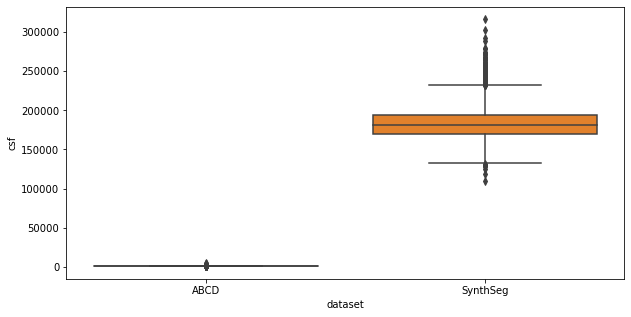

In [27]:
# plot some of the statistically significant features
i = 0
for f, p in zip(methods_all_stats["feature"], methods_all_stats["p_value"]):
    plot=False
    if "ctx" in f:
        continue
    if "amygdala" in f:
        plot=False
    if "hippocampus" in f:
        plot=False
    if "caudate" in f:
        plot=False
    if "white matter" in f:
        plot=False
    if "csf" in f:
        plot=True 
    if plot == True:
        print(f, p)
        abcd_vs_synthseg.plot_feat(f)
    #if i == 10:
    #    break
    print(f)
    #abcd_vs_synthseg.plot_feat(f)
    i += 1

# Figures

TODO:
- bar plot of different manufacturers
- mean/std of different manufacturers
- linear regression plot of SynthSeg+ volumes vs FreeSurfer

In [28]:
fig_dir = "../../figures/"

In [29]:
experiments

,dataset,manufacturers,n_sig_regions
0,abcd,"(Siemens, GE)",77
1,abcd,"(Siemens, Philips)",71
2,abcd,"(GE, Philips)",79
3,synthseg,"(Siemens, GE)",63
4,synthseg,"(Siemens, Philips)",69
5,synthseg,"(GE, Philips)",39
6,synthseg-qc,"(Siemens, GE)",64
7,synthseg-qc,"(Siemens, Philips)",60
8,synthseg-qc,"(GE, Philips)",41
9,abcd-subset,"(Siemens, GE)",70


Bar plot of different manufacturers

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


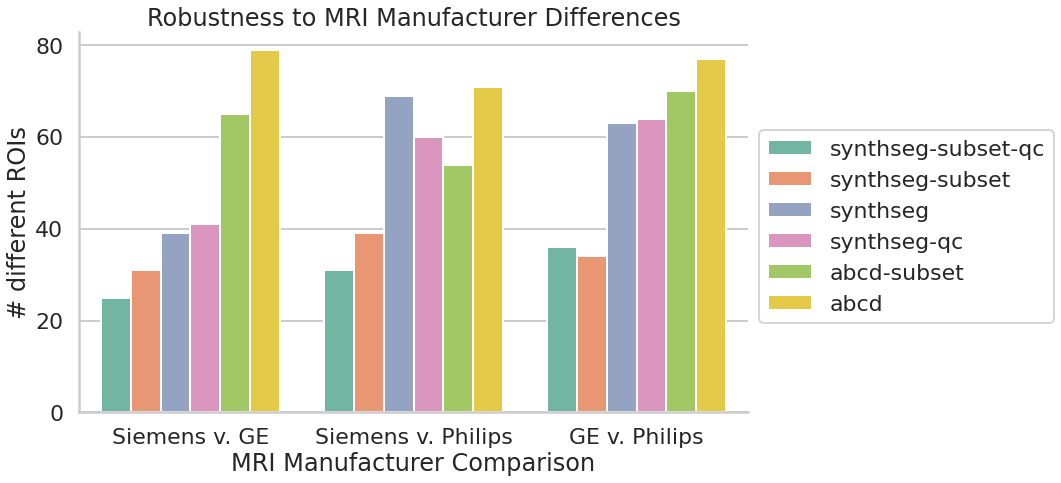

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))


sns.set_style("whitegrid")
sns.set_context("poster") # paper, talk, notebook
sns.set_palette("Set2")

fig =sns.barplot(data=experiments.sort_values(by=['n_sig_regions', 'manufacturers']), x="manufacturers", y="n_sig_regions", hue="dataset")

fig.set(title="Robustness to MRI Manufacturer Differences")
fig.set(xlabel='MRI Manufacturer Comparison', ylabel='# different ROIs')
fig.set_xticklabels(["Siemens v. GE", "Siemens v. Philips", "GE v. Philips"])
fig.legend(bbox_to_anchor=(1.0, 0.77))

sns.despine()

plt.savefig(
    f"{fig_dir}manufact_diff_bar" + ".eps",
    format="eps",
)

# Build dataset

In [31]:
# SynthSeg
ss = synthseg.df["total intracranial"].to_frame()
ss["source"] = ["synthseg" for i in range(len(synthseg.df["total intracranial"]))]
ss["manufacturer"] = scanners

# SynthSeg + QC
ssqc = synthseg.qc_df["total intracranial"].to_frame()
ssqc["source"] = ["synthseg+qc" for i in range(len(synthseg.qc_df["total intracranial"]))]
ssqc["manufacturer"] = qc_scanners

# ABCD
fs = abcd.df["total intracranial"].to_frame()
fs["source"] = ["freesurfer" for i in range(len(abcd.df["total intracranial"]))]
fs["manufacturer"] = scanners

In [32]:
df = pd.concat([ss, ssqc, fs], axis='index')
df.head()

,total intracranial,source,manufacturer
NDARINVW1J6282F,1527221.0,synthseg,Siemens
NDARINVW1M7NAKA,1356769.5,synthseg,Siemens
NDARINVW26YNDL9,1570371.2,synthseg,Siemens
NDARINVW2DZTWZ2,1547157.1,synthseg,Siemens
NDARINVW2GVHACV,1585975.8,synthseg,Siemens


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


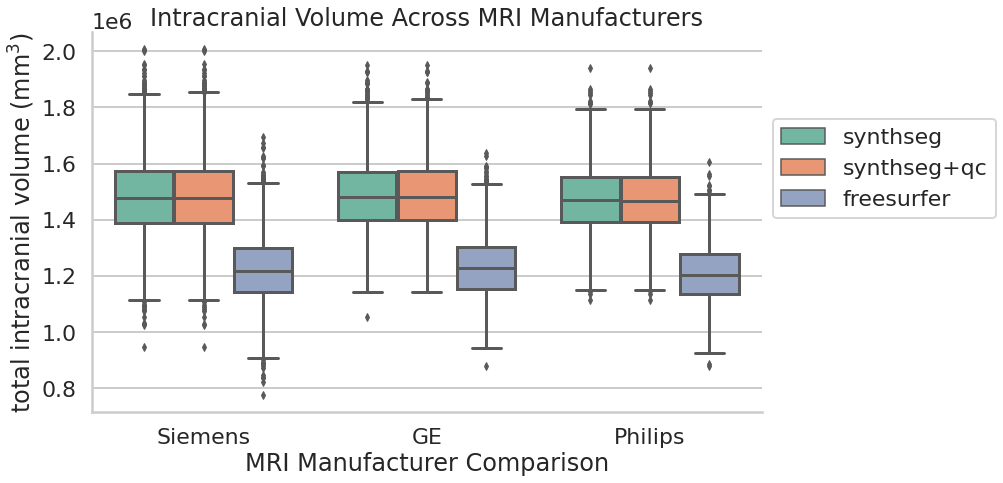

In [33]:
plt.figure(figsize=(12,7))


sns.set_style("whitegrid")
sns.set_context("poster") # paper, talk, notebook
sns.set_palette("Set2")

fig = sns.boxplot(data=df, x="manufacturer", y="total intracranial", hue="source")

fig.set(title="Intracranial Volume Across MRI Manufacturers")
fig.set(xlabel='MRI Manufacturer Comparison', ylabel='total intracranial volume (mm$^3$)')
fig.legend(bbox_to_anchor=(1.0, 0.8))

sns.despine()

plt.savefig(
    f"{fig_dir}manufact_diff_box" + ".eps",
    format="eps",
)

In [34]:
df[df["source"] == "synthseg"]

,total intracranial,source,manufacturer
NDARINVW1J6282F,1527221.0,synthseg,Siemens
NDARINVW1M7NAKA,1356769.5,synthseg,Siemens
NDARINVW26YNDL9,1570371.2,synthseg,Siemens
NDARINVW2DZTWZ2,1547157.1,synthseg,Siemens
NDARINVW2GVHACV,1585975.8,synthseg,Siemens
...,...,...,...
NDARINV1BR989ED,1319829.1,synthseg,Philips
NDARINV1BTYWJDX,1534436.1,synthseg,Siemens
NDARINV1BUXN6LH,1606058.8,synthseg,Siemens
NDARINV1BZ0TUT9,1367924.6,synthseg,Siemens


NameError: name 'x1' is not defined

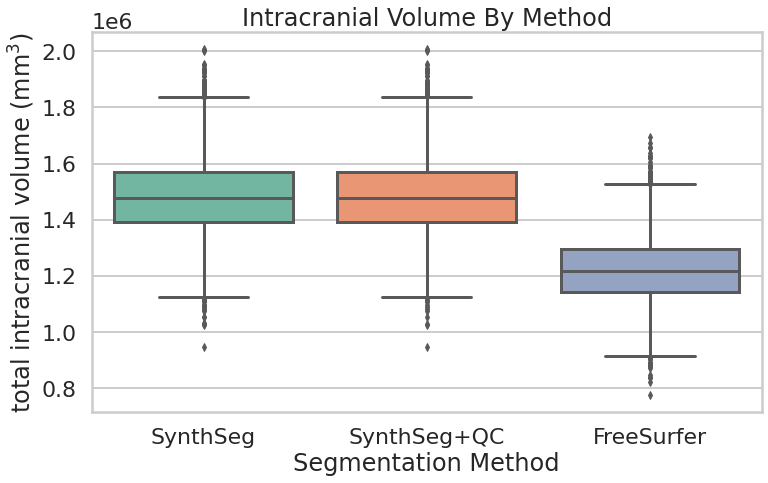

In [35]:
plt.figure(figsize=(12,7))


sns.set_style("whitegrid")
sns.set_context("poster") # paper, talk, notebook
sns.set_palette("Set2")

fig = sns.boxplot(data=df, x="source", y="total intracranial")

fig.set(title="Intracranial Volume By Method")
fig.set(xlabel='Segmentation Method', ylabel='total intracranial volume (mm$^3$)')
fig.set_xticklabels(["SynthSeg", "SynthSeg+QC", "FreeSurfer"])

plt.plot(
    ["synthseg", x1, x2, x2],
    [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
)


sns.despine()

plt.savefig(
    f"{fig_dir}dataset_diff" + ".eps",
    format="eps",
)

In [ ]:
df["total intracranial"][df["source"] == "synthseg"]

NDARINVW1J6282F    1527221.0
NDARINVW1M7NAKA    1356769.5
NDARINVW26YNDL9    1570371.2
NDARINVW2DZTWZ2    1547157.1
NDARINVW2GVHACV    1585975.8
                     ...    
NDARINV1BR989ED    1319829.1
NDARINV1BTYWJDX    1534436.1
NDARINV1BUXN6LH    1606058.8
NDARINV1BZ0TUT9    1367924.6
NDARINV1CC6HB4A    1530301.1
Name: total intracranial, Length: 11402, dtype: float64

In [ ]:
# Assume both are normal bc N > 5000
# Dependent
from scipy import stats

_, p = stats.ttest_rel(df["total intracranial"][df["source"] == "synthseg"], df["total intracranial"][df["source"] == "freesurfer"])

print(p)

0.0


In [ ]:
_, p = stats.ttest_rel(df["total intracranial"][df["source"] == "synthseg+qc"], df["total intracranial"][df["source"] == "freesurfer"][:9306])

print(p)

0.0


In [ ]:
_, p = stats.ttest_rel(df["total intracranial"][df["source"] == "synthseg"][:9306], df["total intracranial"][df["source"] == "synthseg+qc"])
p

0.6703292059990911